In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

2021-10-14 20:09:39.194412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    
    
    for label in labels:
        DIR = dir_path + label
        #n = 0
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            #while n < size:
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
                
                #n += 1
            
    ## Transform labels in Z to Y from class number
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X, dtype=float)
    X=X/255.
    return X, Y

In [3]:
dir_path = dir_path = '/kaggle/input/auckland-zoo-monkeys/Auckland_Zoo_Monkeys/'

labels = ['Arani', 'Inti', 'Ocuri', 'Poco', 'Rattaplan', 'Romy']

# randomly select seen datset and unseen dataset
# make open set and unseen set 
def make_seen_unseen(labels, num_seen):
    arr = np.arange(len(labels))
    np.random.shuffle(arr)
    
    labels_seen = [labels[i] for i in arr[:num_seen]]
    labels_unseen = [labels[i] for i in arr[num_seen:]]
    
    X_seen, Y_seen = make_dataset(labels_seen, dir_path)
    X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
    Y_unseen = ['unseen'] * len(Y_unseen)
    Y_unseen = np.array(Y_unseen)
    return X_seen, Y_seen, X_unseen, Y_unseen
labels = ['Arani', 'Inti', 'Ocuri', 'Poco', 'Rattaplan', 'Romy']

# randomly select seen datset and unseen dataset
# make open set and unseen set 
def make_seen_unseen(labels, num_seen):
    arr = np.arange(len(labels))
    np.random.shuffle(arr)
    
    labels_seen = [labels[i] for i in arr[:num_seen]]
    labels_unseen = [labels[i] for i in arr[num_seen:]]
    
    X_seen, Y_seen = make_dataset(labels_seen, dir_path)
    X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
    Y_unseen = ['unseen'] * len(Y_unseen)
    Y_unseen = np.array(Y_unseen)
    return X_seen, Y_seen, X_unseen, Y_unseen

# Configuration Settings

In [4]:
imsize = 150
EPOCHS = 10
batch_size = 64
embeddingDim = 128
num_individuals = len(labels)

In [5]:
X_seen, Y_seen, X_unseen, Y_unseen = make_seen_unseen(labels, num_individuals - 1)

100%|██████████| 285/285 [00:03<00:00, 83.33it/s]


# Train/test set split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)

X_val_unseen, X_test_unseen, Y_val_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.5, random_state=2021)

## Exploring the dataset

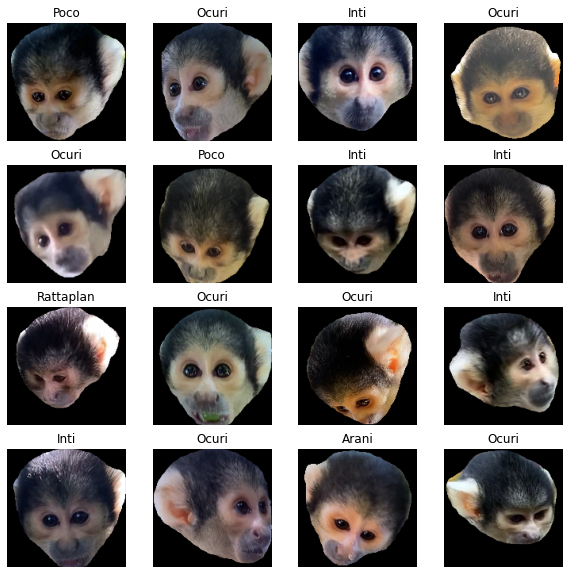

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis("off")

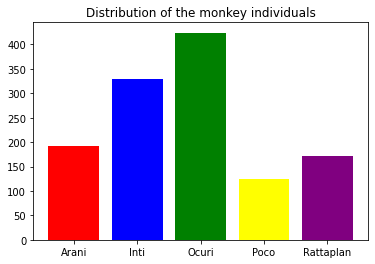

In [8]:
classes, counts = np.unique(Y_train, return_counts = True)

plt.bar(np.array(labels)[classes], counts, color=['red', 'blue', 'green', 'yellow', 'purple'])
plt.title('Distribution of the monkey individuals')
plt.show()

# Stratified 5 fold Cross Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)

# VGG16 Classification Model

In [10]:
def evaluate_vgg16(lr):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_vgg_16 = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(units=num_individuals, activation='softmax')
    ])

    model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

    model_vgg_16.fit(x=x_train, y=y_train,
                     epochs=EPOCHS,
                     batch_size=batch_size,
                     verbose=1)
    
    acc = model_vgg_16.evaluate(x_val, y_val)[1]
    
    return acc

In [11]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

terms = {}
for i in lr:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in lr:
        terms['{}'.format(i)].append(evaluate_vgg16(lr = i))

2021-10-14 20:10:08.057719: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-14 20:10:08.061037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-14 20:10:08.099110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 20:10:08.099765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-14 20:10:08.099847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-14 20:10:08.126563: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step


2021-10-14 20:10:11.130500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-14 20:10:11.142198: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


Epoch 1/10


2021-10-14 20:10:11.736792: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-14 20:10:12.463396: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-14 20:10:12.489619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


16/16 [==============================] - 11s 158ms/step - loss: 1.5962 - acc: 0.3239
Epoch 2/10
16/16 [==============================] - 1s 64ms/step - loss: 1.3952 - acc: 0.4566
Epoch 3/10
16/16 [==============================] - 1s 63ms/step - loss: 1.2517 - acc: 0.5277
Epoch 4/10
16/16 [==============================] - 1s 64ms/step - loss: 1.1771 - acc: 0.5616
Epoch 5/10
16/16 [==============================] - 1s 67ms/step - loss: 1.0952 - acc: 0.5940
Epoch 6/10
16/16 [==============================] - 1s 63ms/step - loss: 0.9942 - acc: 0.6677
Epoch 7/10
16/16 [==============================] - 1s 63ms/step - loss: 0.9411 - acc: 0.7265
Epoch 8/10
16/16 [==============================] - 1s 62ms/step - loss: 0.8768 - acc: 0.7326
Epoch 9/10
16/16 [==============================] - 1s 63ms/step - loss: 0.8282 - acc: 0.7491
Epoch 10/10
8/8 [==============================] - 2s 200ms/step - loss: 0.9475 - acc: 0.6667
Epoch 1/10
16/16 [==============================] - 1s 63ms/step - lo

In [12]:
import pandas as pd
acc_vgg16 = pd.DataFrame(terms)
table_vgg16 = acc_vgg16.agg(['mean', 'std']).T
table_vgg16

,mean,std
1e-05,0.705914,0.036481
0.0001,0.883188,0.023100
0.001,0.901726,0.027514
0.01,0.897691,0.022529
0.1,0.384386,0.083059


In [13]:
! pip install autorank
from autorank import autorank, plot_stats, create_report

## Statistical tests

In [14]:
results = autorank(acc_vgg16, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
        meanrank    median       mad  ci_lower  ci_upper effect_size  \
0.001        1.7  0.903226  0.011957  0.859438  0.935484         0.0   
0.01         1.8  0.907258  0.017935  0.863454  0.919355    -0.26456   
0.0001       2.5  0.891129  0.023913   0.84739  0.907258    0.639877   
1e-05        4.0  0.705645  0.041848  0.666667  0.758065    6.420211   
0.1          5.0  0.342742       0.0  0.342742  0.532258   66.293812   

         magnitude  
0.001   negligible  
0.01         small  
0.0001      medium  
1e-05        large  
0.1          large  
pvalue=0.0018466678790680076
cd=2.7277508838690387
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[0.8011016249656677, 0.6263763904571533, 0.6939250230789185, 0.4703548848628998, 0.0010428791865706444]
homoscedastic=True
pval_homogeneity=0.8275863552776228
homogeneity_test=levene
alpha=0.05
alpha_normality=0.01
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_s

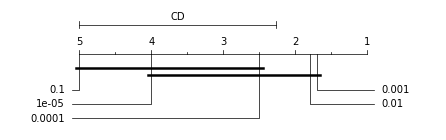

In [15]:
plot_stats(results)
plt.show()

In [16]:
create_report(results)

The statistical analysis was conducted for 5 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population 0.1 (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.728 of the Nemenyi test.
We reject the null hypothesis (p=0.002) of the Friedman test that there is no difference in the ce

In [17]:
acc_best_vgg16 =  acc_vgg16['0.001']
acc_best_vgg16

0    0.859438
1    0.935484
2    0.903226
3    0.899194
4    0.911290
Name: 0.001, dtype: float64

# Retrain VGG16 classification model on training set + val set, test it on test set

In [18]:
# choose best lr
lr = 0.001

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=num_individuals, activation='softmax')
])

model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

model_vgg_16.fit(x=X_train, y=Y_train,
                 epochs=EPOCHS,
                 batch_size=batch_size,
                 verbose=1)

Epoch 1/10
20/20 [==============================] - 2s 64ms/step - loss: 4.2888 - acc: 0.3034
Epoch 2/10
20/20 [==============================] - 1s 62ms/step - loss: 0.7735 - acc: 0.7003
Epoch 3/10
20/20 [==============================] - 1s 63ms/step - loss: 0.3935 - acc: 0.8745
Epoch 4/10
20/20 [==============================] - 1s 64ms/step - loss: 0.2377 - acc: 0.9443
Epoch 5/10
20/20 [==============================] - 1s 63ms/step - loss: 0.1587 - acc: 0.9779
Epoch 6/10
20/20 [==============================] - 1s 63ms/step - loss: 0.1267 - acc: 0.9825
Epoch 7/10
20/20 [==============================] - 1s 64ms/step - loss: 0.0982 - acc: 0.9872
Epoch 8/10
20/20 [==============================] - 1s 65ms/step - loss: 0.0672 - acc: 0.9987
Epoch 9/10
20/20 [==============================] - 1s 63ms/step - loss: 0.0492 - acc: 1.0000
Epoch 10/10
20/20 [==============================] - 1s 64ms/step - loss: 0.0419 - acc: 1.0000


In [19]:
acc_test_vgg16 = round(model_vgg_16.evaluate(X_test, Y_test)[1], 2)

print('Accuracy of VGG16 on the test set is {}'.format(acc_test_vgg16))

10/10 [==============================] - 2s 153ms/step - loss: 0.2273 - acc: 0.9132
Accuracy of VGG16 on the test set is 0.91


# Contrastive Loss

In [20]:
# Helper Function 

# Create positive pairs and negative pairs
import random
def create_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(num_individuals)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))



# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

## Closed Set

In [21]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_cl_closed_set(lr, k):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize,imsize,3),
                                                      weights = 'imagenet')
    
    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
              batch_size = batch_size,
              epochs=EPOCHS, 
              verbose=1)
    
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    x_test_embedding = model_cl.predict(x_val)
    acc = round(knn_cl.score(x_test_embedding, y_val), 2)
    print('Accuracy on the val set with contrastive loss is {}'.format(acc))
    
    return acc

In [22]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k = [1, 3, 5]

terms = {}
for i in lr:
    for j in k:
        terms['{}_{}'.format(i, j)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    (pairTrain, labelTrain) = create_pairs(x_train, y_train)
    
    for i in lr:
        for j in k:
            terms['{}_{}'.format(i, j)].append(evaluate_cl_closed_set(lr = i, k = j))

Epoch 1/10
31/31 [==============================] - 5s 126ms/step - loss: 0.2478
Epoch 2/10
31/31 [==============================] - 4s 126ms/step - loss: 0.2367
Epoch 3/10
31/31 [==============================] - 4s 126ms/step - loss: 0.2296
Epoch 4/10
31/31 [==============================] - 4s 129ms/step - loss: 0.2177
Epoch 5/10
31/31 [==============================] - 4s 124ms/step - loss: 0.2115
Epoch 6/10
31/31 [==============================] - 4s 126ms/step - loss: 0.1985
Epoch 7/10
31/31 [==============================] - 4s 125ms/step - loss: 0.1923
Epoch 8/10
31/31 [==============================] - 4s 126ms/step - loss: 0.1835
Epoch 9/10
31/31 [==============================] - 4s 125ms/step - loss: 0.1770
Epoch 10/10
31/31 [==============================] - 4s 125ms/step - loss: 0.1658
Accuracy on the val set with contrastive loss is 0.84
Epoch 1/10
31/31 [==============================] - 5s 129ms/step - loss: 0.2499
Epoch 2/10
31/31 [==============================] - 4s

In [23]:
import pandas as pd
acc_cl_closed_set = pd.DataFrame(terms)
table_cl_closed_set = acc_cl_closed_set.agg(['mean', 'std']).T
table_cl_closed_set

,mean,std
1e-05_1,0.848,0.021679
1e-05_3,0.824,0.023022
1e-05_5,0.794,0.032094
0.0001_1,0.884,0.021909
0.0001_3,0.882,0.036332
0.0001_5,0.882,0.029496
0.001_1,0.868,0.019235
0.001_3,0.852,0.025884
0.001_5,0.856,0.023022
0.01_1,0.768,0.029496


## Statistical tests

In [24]:
results = autorank(acc_cl_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
          meanrank   mean       std  ci_lower  ci_upper effect_size  \
0.0001_1       2.0  0.884  0.021909  0.851538  0.916462         0.0   
0.0001_5       2.5  0.882  0.029496  0.849538  0.914462     0.07698   
0.0001_3       2.9  0.882  0.036332  0.849538  0.914462    0.066667   
0.001_1        4.3  0.868  0.019235  0.835538  0.900462    0.776114   
0.001_5        5.2  0.856  0.023022  0.823538  0.888462    1.245984   
1e-05_1        5.6  0.848  0.021679  0.815538  0.880462    1.651793   
0.001_3        6.2  0.852  0.025884  0.819538  0.884462    1.334492   
1e-05_3        7.7  0.824  0.023022  0.791538  0.856462    2.669965   
0.01_5        10.4  0.784  0.048785  0.751538  0.816462    2.644429   
1e-05_5       10.5  0.794  0.032094  0.761538  0.826462    3.275435   
0.01_3        10.5  0.794  0.028810  0.761538  0.826462    3.516591   
0.01_1        11.9  0.768  0.029496  0.735538  0.800462    4.464842   
0.1_1         13.0  0.744  0.042190  0.711538  0.776462   

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


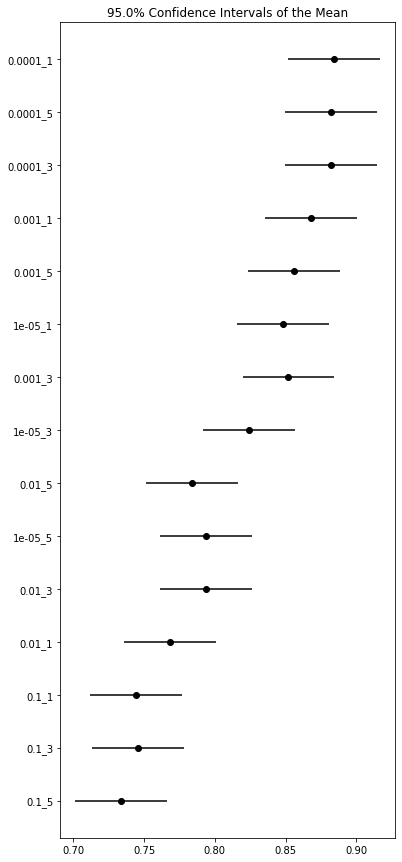

In [25]:
plot_stats(results)
plt.show()

In [26]:
create_report(results)

The statistical analysis was conducted for 15 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.006). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.672) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confid

In [27]:
acc_best_cl_closed_set =  acc_cl_closed_set['0.0001_1']
acc_best_cl_closed_set

0    0.86
1    0.90
2    0.86
3    0.90
4    0.90
Name: 0.0001_1, dtype: float64

## Retrain Contrastive Loss on training set + val set, and test it on test set

In [28]:
from sklearn.neighbors import KNeighborsClassifier

# choose best lr and k
lr = 0.0001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

    
imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
featsA = model_cl(imgA)
featsB = model_cl(imgB)
   
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1)
    
embedding_train_cl = []
for i in range(len(Y_train)):
        embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
x_test_embedding = model_cl.predict(X_test)
acc_cl_test_closed_set = round(knn_cl.score(x_test_embedding, Y_test), 2)

print('Accuracy of Constractive Loss on test set is {}'.format(round(acc_cl_test_closed_set, 2)))

2021-10-14 21:55:59.871720: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 670140000 exceeds 10% of free system memory.
2021-10-14 21:56:00.642535: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 670140000 exceeds 10% of free system memory.


Epoch 1/10
39/39 [==============================] - 10s 238ms/step - loss: 0.2450
Epoch 2/10
39/39 [==============================] - 5s 124ms/step - loss: 0.1739
Epoch 3/10
39/39 [==============================] - 5s 125ms/step - loss: 0.1403
Epoch 4/10
39/39 [==============================] - 5s 125ms/step - loss: 0.1125
Epoch 5/10
39/39 [==============================] - 5s 127ms/step - loss: 0.0961
Epoch 6/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0776
Epoch 7/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0672
Epoch 8/10
39/39 [==============================] - 5s 126ms/step - loss: 0.0595
Epoch 9/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0487
Epoch 10/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0460
Accuracy of Constractive Loss on test set is 0.94


## Open Set

In [29]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_cl_open_set(lr=0.0001, k = 1, d_t = 0.5):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize,imsize,3),
                                                      weights = 'imagenet')
    
    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
              batch_size = batch_size,
              epochs=EPOCHS, 
              verbose=1)
    
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    #find the center point for each class in training set
    support_cl = []
    for i in np.unique(y_train):
        support_cl.append(np.mean(embedding_train_cl[y_train==i], axis=0))
        
    support_cl = np.array(support_cl, dtype=float)
    
    pred = []
    temp_x = np.append(x_val, X_val_unseen, axis=0)
    temp_y = np.append(y_val, Y_val_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_cl.predict(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_cl[j]
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        if min(dists) >= d_t:
            pred.append('unseen')
        else:
            pred.append(knn_cl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the val set with Contrastive Loss is {}'.format(acc_open))
    
    return acc_open

In [30]:
d_t = [0.4, 0.5, 0.6, 0.7, 0.8]

terms = {}
for i in d_t:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    (pairTrain, labelTrain) = create_pairs(x_train, y_train)
    
    for i in d_t:
        terms['{}'.format(i)].append(evaluate_cl_open_set(d_t = i))

Epoch 1/10
31/31 [==============================] - 5s 125ms/step - loss: 0.2477
Epoch 2/10
31/31 [==============================] - 4s 125ms/step - loss: 0.1778
Epoch 3/10
31/31 [==============================] - 4s 126ms/step - loss: 0.1397
Epoch 4/10
31/31 [==============================] - 4s 125ms/step - loss: 0.1128
Epoch 5/10
31/31 [==============================] - 4s 125ms/step - loss: 0.0983
Epoch 6/10
31/31 [==============================] - 4s 125ms/step - loss: 0.0815
Epoch 7/10
31/31 [==============================] - 4s 126ms/step - loss: 0.0663
Epoch 8/10
31/31 [==============================] - 4s 127ms/step - loss: 0.0589
Epoch 9/10
31/31 [==============================] - 4s 124ms/step - loss: 0.0492
Epoch 10/10
31/31 [==============================] - 4s 125ms/step - loss: 0.0408
The accuracy on the val set with Contrastive Loss is 0.61
Epoch 1/10
31/31 [==============================] - 5s 125ms/step - loss: 0.2445
Epoch 2/10
31/31 [==============================] 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
31/31 [==============================] - 5s 126ms/step - loss: 0.2497
Epoch 2/10
31/31 [==============================] - 4s 125ms/step - loss: 0.1782
Epoch 3/10
31/31 [==============================] - 4s 125ms/step - loss: 0.1470
Epoch 4/10
31/31 [==============================] - 4s 126ms/step - loss: 0.1146
Epoch 5/10
31/31 [==============================] - 4s 126ms/step - loss: 0.0945
Epoch 6/10
31/31 [==============================] - 4s 125ms/step - loss: 0.0787
Epoch 7/10
31/31 [==============================] - 4s 125ms/step - loss: 0.0703
Epoch 8/10
31/31 [==============================] - 4s 127ms/step - loss: 0.0577
Epoch 9/10
31/31 [==============================] - 4s 125ms/step - loss: 0.0490
Epoch 10/10
31/31 [==============================] - 4s 125ms/step - loss: 0.0422
The accuracy on the val set with Contrastive Loss is 0.56
Epoch 1/10
31/31 [==============================] - 5s 126ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 124ms/step - loss: 0.2426
Epoch 2/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1835
Epoch 3/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1460
Epoch 4/10
32/32 [==============================] - 4s 123ms/step - loss: 0.1206
Epoch 5/10
32/32 [==============================] - 4s 123ms/step - loss: 0.1089
Epoch 6/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0949
Epoch 7/10
32/32 [==============================] - 4s 123ms/step - loss: 0.0866
Epoch 8/10
32/32 [==============================] - 4s 123ms/step - loss: 0.0722
Epoch 9/10
32/32 [==============================] - 4s 123ms/step - loss: 0.0649
Epoch 10/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0596
The accuracy on the val set with Contrastive Loss is 0.6
Epoch 1/10
32/32 [==============================] - 5s 123ms/step - loss: 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 123ms/step - loss: 0.2465
Epoch 2/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1954
Epoch 3/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1525
Epoch 4/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1274
Epoch 5/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1071
Epoch 6/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0898
Epoch 7/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0888
Epoch 8/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0836
Epoch 9/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0725
Epoch 10/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0734
The accuracy on the val set with Contrastive Loss is 0.64
Epoch 1/10
32/32 [==============================] - 5s 123ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 122ms/step - loss: 0.2513
Epoch 2/10
32/32 [==============================] - 4s 124ms/step - loss: 0.1821
Epoch 3/10
32/32 [==============================] - 4s 123ms/step - loss: 0.1502
Epoch 4/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1341
Epoch 5/10
32/32 [==============================] - 4s 123ms/step - loss: 0.1155
Epoch 6/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0959
Epoch 7/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0852
Epoch 8/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0776
Epoch 9/10
32/32 [==============================] - 4s 123ms/step - loss: 0.0701
Epoch 10/10
32/32 [==============================] - 4s 124ms/step - loss: 0.0587
The accuracy on the val set with Contrastive Loss is 0.56
Epoch 1/10
32/32 [==============================] - 5s 123ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 125ms/step - loss: 0.2452
Epoch 2/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1801
Epoch 3/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1497
Epoch 4/10
32/32 [==============================] - 4s 123ms/step - loss: 0.1247
Epoch 5/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1123
Epoch 6/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0989
Epoch 7/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0764
Epoch 8/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0752
Epoch 9/10
32/32 [==============================] - 4s 124ms/step - loss: 0.0643
Epoch 10/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0732


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 123ms/step - loss: 0.2564
Epoch 2/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1837
Epoch 3/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1480
Epoch 4/10
32/32 [==============================] - 4s 123ms/step - loss: 0.1274
Epoch 5/10
32/32 [==============================] - 4s 123ms/step - loss: 0.1061
Epoch 6/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0999
Epoch 7/10
32/32 [==============================] - 4s 120ms/step - loss: 0.0879
Epoch 8/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0776
Epoch 9/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0663
Epoch 10/10
32/32 [==============================] - 4s 120ms/step - loss: 0.0623


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 123ms/step - loss: 0.2456
Epoch 2/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1798
Epoch 3/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1528
Epoch 4/10
32/32 [==============================] - 4s 124ms/step - loss: 0.1246
Epoch 5/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1079
Epoch 6/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0946
Epoch 7/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0837
Epoch 8/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0732
Epoch 9/10
32/32 [==============================] - 4s 123ms/step - loss: 0.0620
Epoch 10/10
32/32 [==============================] - 4s 123ms/step - loss: 0.0557


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 120ms/step - loss: 0.2461
Epoch 2/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1852
Epoch 3/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1531
Epoch 4/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1307
Epoch 5/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1063
Epoch 6/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0937
Epoch 7/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0818
Epoch 8/10
32/32 [==============================] - 4s 120ms/step - loss: 0.0734
Epoch 9/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0605
Epoch 10/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0619
The accuracy on the val set with Contrastive Loss is 0.62
Epoch 1/10
32/32 [==============================] - 5s 121ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 122ms/step - loss: 0.2417
Epoch 2/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1859
Epoch 3/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1536
Epoch 4/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1273
Epoch 5/10
32/32 [==============================] - 4s 122ms/step - loss: 0.1114
Epoch 6/10
32/32 [==============================] - 4s 120ms/step - loss: 0.1003
Epoch 7/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0880
Epoch 8/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0738
Epoch 9/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0662
Epoch 10/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0615


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
32/32 [==============================] - 5s 120ms/step - loss: 0.2401
Epoch 2/10
32/32 [==============================] - 4s 123ms/step - loss: 0.1792
Epoch 3/10
32/32 [==============================] - 4s 120ms/step - loss: 0.1505
Epoch 4/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1224
Epoch 5/10
32/32 [==============================] - 4s 121ms/step - loss: 0.1165
Epoch 6/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0955
Epoch 7/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0799
Epoch 8/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0709
Epoch 9/10
32/32 [==============================] - 4s 121ms/step - loss: 0.0780
Epoch 10/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0746
The accuracy on the val set with Contrastive Loss is 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [31]:
import pandas as pd
acc_cl_open_set = pd.DataFrame(terms)
table_cl_open_set = acc_cl_open_set.agg(['mean', 'std']).T
table_cl_open_set

,mean,std
0.4,0.606,0.029665
0.5,0.468,0.261763
0.6,0.226,0.309483
0.7,0.342,0.312282
0.8,0.000,0.000000


## Statistical tests

In [32]:
results = autorank(acc_cl_open_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
     meanrank  median       mad ci_lower ci_upper effect_size   magnitude
0.4       1.0    0.61  0.014826     0.56     0.64         0.0  negligible
0.5       2.5    0.59       0.0      0.0     0.59    1.907748       large
0.7       3.2    0.56  0.029652      0.0     0.58    2.132927       large
0.6       3.9    0.00       0.0      0.0     0.57   58.186313       large
0.8       4.4    0.00       0.0      0.0      0.0   58.186313       large
pvalue=0.0021047769948596504
cd=2.7277508838690387
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[0.7772533297538757, 0.0002826813142746687, 0.00743243470788002, 0.009901918470859528, 1.0]
homoscedastic=True
pval_homogeneity=0.3546571410078179
homogeneity_test=levene
alpha=0.05
alpha_normality=0.01
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=akinshin_gamma)


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


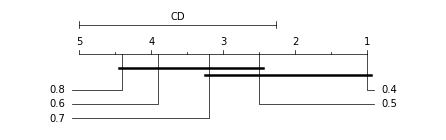

In [33]:
plot_stats(results)
plt.show()

In [34]:
create_report(results)

The statistical analysis was conducted for 5 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations 0.5 (p=0.000), 0.7 (p=0.007), and 0.6 (p=0.010). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.728 of the Nemenyi test.
We reject the null hypothesis (p=0.002) of the Friedman test 

In [35]:
acc_best_cl_open_set =  acc_cl_open_set['0.4']
acc_best_cl_open_set

0    0.61
1    0.60
2    0.64
3    0.56
4    0.62
Name: 0.4, dtype: float64

## Retrain Contrastive Loss on training set + val set, and test it on test set

In [36]:
from sklearn.neighbors import KNeighborsClassifier

# choose the best value of d_t
lr = 0.0001
k = 1
d_t = 0.4

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))

featsA = model_cl(imgA)
featsB = model_cl(imgB)

distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)

model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1)

embedding_train_cl = []
for i in range(len(Y_train)):
    embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])

embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
#find the center point for each class in training set
support_cl = []
for i in np.unique(Y_train):
    support_cl.append(np.mean(embedding_train_cl[Y_train==i], axis=0))
        
support_cl = np.array(support_cl, dtype=float)
    
pred = []
temp_x = np.append(X_test, X_val_unseen, axis=0)
temp_y = np.append(Y_test, Y_val_unseen, axis=0)
    
arr = np.arange(temp_y.shape[0])
np.random.shuffle(arr)
    
temp_x = temp_x[arr]
temp_y = temp_y[arr]
    
for i in range(len(temp_y)):
    dists = []
    for j in range(len(np.unique(Y_train))):
        embedding_test = model_cl.predict(temp_x[i].reshape(1, 150, 150, 3))
        embedding_anchor = support_cl[j]
        dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
        dists.append(dist)
    if min(dists) >= d_t:
            pred.append('unseen')
    else:
        pred.append(knn_cl.predict(embedding_test)[0])

pred = np.array(pred)
    
acc_cl_test_open_set = round(np.mean(pred == temp_y), 2)
print('The accuracy on the test set with Open Dataset of Contrastive Loss is {}'.format(acc_cl_test_open_set))

2021-10-14 23:01:19.586830: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 670140000 exceeds 10% of free system memory.
2021-10-14 23:01:20.331122: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 670140000 exceeds 10% of free system memory.


Epoch 1/10
39/39 [==============================] - 6s 126ms/step - loss: 0.2472
Epoch 2/10
39/39 [==============================] - 5s 124ms/step - loss: 0.1765
Epoch 3/10
39/39 [==============================] - 5s 127ms/step - loss: 0.1386
Epoch 4/10
39/39 [==============================] - 5s 124ms/step - loss: 0.1146
Epoch 5/10
39/39 [==============================] - 5s 124ms/step - loss: 0.0945
Epoch 6/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0776
Epoch 7/10
39/39 [==============================] - 5s 123ms/step - loss: 0.0642
Epoch 8/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0563
Epoch 9/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0465
Epoch 10/10
39/39 [==============================] - 5s 126ms/step - loss: 0.0416
The accuracy on the test set with Open Dataset of Contrastive Loss is 0.66


# Triplet Loss

## Closed Set

In [37]:
def evaluate_tl_closed_set(lr, k):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS,
                 verbose=1) 
        
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    x_test_embedding = model_tl.predict(x_val)
    acc = round(knn_tl.score(x_test_embedding, y_val), 2)
    print('Accuracy on the the val set with Tripolet Loss is {}'.format(acc))
    
    return acc

In [38]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k = [1, 3, 5]

terms = {}
for i in lr:
    for j in k:
        terms['{}_{}'.format(i, j)] = []
        
for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in lr:
        for j in k:
            terms['{}_{}'.format(i, j)].append(evaluate_tl_closed_set(lr = i, k = j))

Epoch 1/10
16/16 [==============================] - 3s 63ms/step - loss: 0.9935
Epoch 2/10
16/16 [==============================] - 1s 63ms/step - loss: 0.9917
Epoch 3/10
16/16 [==============================] - 1s 63ms/step - loss: 0.9896
Epoch 4/10
16/16 [==============================] - 1s 62ms/step - loss: 0.9836
Epoch 5/10
16/16 [==============================] - 1s 64ms/step - loss: 0.9772
Epoch 6/10
16/16 [==============================] - 1s 65ms/step - loss: 0.9622
Epoch 7/10
16/16 [==============================] - 1s 64ms/step - loss: 0.9425
Epoch 8/10
16/16 [==============================] - 1s 63ms/step - loss: 0.9288
Epoch 9/10
16/16 [==============================] - 1s 62ms/step - loss: 0.9178
Epoch 10/10
16/16 [==============================] - 1s 63ms/step - loss: 0.8936
Accuracy on the the val set with Tripolet Loss is 0.85
Epoch 1/10
16/16 [==============================] - 2s 63ms/step - loss: 0.9933
Epoch 2/10
16/16 [==============================] - 1s 63ms/step

In [39]:
import pandas as pd
acc_tl_closed_set = pd.DataFrame(terms)
table_tl_closed_set = acc_tl_closed_set.agg(['mean', 'std']).T
table_tl_closed_set

,mean,std
1e-05_1,0.884,0.023022
1e-05_3,0.854,0.035071
1e-05_5,0.828,0.036332
0.0001_1,0.898,0.027749
0.0001_3,0.898,0.022804
0.0001_5,0.896,0.023022
0.001_1,0.908,0.013038
0.001_3,0.908,0.017889
0.001_5,0.896,0.016733
0.01_1,0.816,0.032094


## Statistical tests

In [40]:
results = autorank(acc_tl_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
          meanrank   mean       std  ci_lower  ci_upper effect_size  \
0.001_1        2.4  0.908  0.013038  0.874614  0.941386         0.0   
0.001_3        2.4  0.908  0.017889  0.874614  0.941386         0.0   
0.0001_3       3.8  0.898  0.022804  0.864614  0.931386    0.538382   
0.001_5        4.2  0.896  0.016733  0.862614  0.929386         0.8   
0.0001_1       4.3  0.898  0.027749  0.864614  0.931386    0.461266   
0.0001_5       4.5  0.896  0.023022  0.862614  0.929386    0.641427   
1e-05_1        6.4  0.884  0.023022  0.850614  0.917386    1.282854   
1e-05_3        8.6  0.854  0.035071  0.820614  0.887386    2.041008   
1e-05_5       10.3  0.828  0.036332  0.794614  0.861386    2.930973   
0.01_5        10.3  0.824  0.036469  0.790614  0.857386    3.067246   
0.01_1        11.0  0.816  0.032094  0.782614  0.849386    3.755884   
0.01_3        11.0  0.818  0.027749  0.784614  0.851386     4.15139   
0.1_3         13.1  0.786  0.047223  0.752614  0.819386   

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


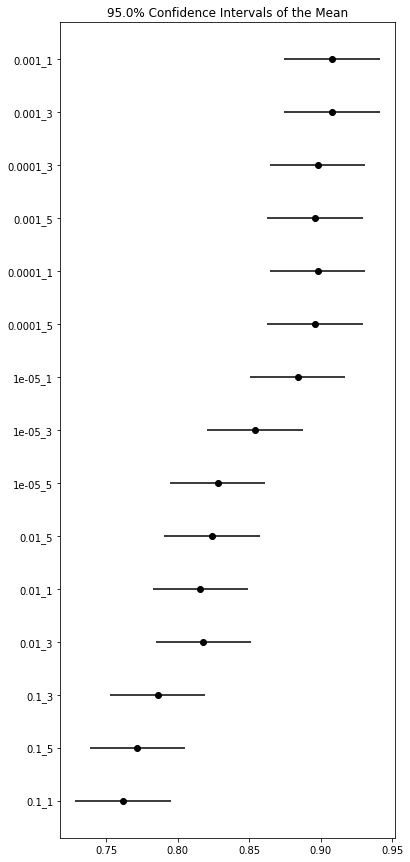

In [41]:
plot_stats(results)
plt.show()

In [42]:
create_report(results)

The statistical analysis was conducted for 15 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.046). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.685) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confid

In [43]:
acc_best_tl_closed_set =  acc_tl_closed_set['0.001_1']
acc_best_tl_closed_set

0    0.89
1    0.92
2    0.92
3    0.90
4    0.91
Name: 0.001_1, dtype: float64

## Retrain Triplet Loss on training set + val set, and test it on test set

In [44]:
# choose best lr and k
lr = 0.001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
        layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x=X_train, y= Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
x_test_embedding = model_tl.predict(X_test)
acc_tl_test_closed_set = round(knn_tl.score(x_test_embedding, Y_test), 2)

print('Accuracy of Triplet Loss on the test set is {}'.format(round(acc_tl_test_closed_set, 2)))

Epoch 1/10
20/20 [==============================] - 2s 65ms/step - loss: 0.9713
Epoch 2/10
20/20 [==============================] - 1s 63ms/step - loss: 0.8650
Epoch 3/10
20/20 [==============================] - 1s 63ms/step - loss: 0.7585
Epoch 4/10
20/20 [==============================] - 1s 63ms/step - loss: 0.7119
Epoch 5/10
20/20 [==============================] - 1s 63ms/step - loss: 0.5650
Epoch 6/10
20/20 [==============================] - 1s 63ms/step - loss: 0.5172
Epoch 7/10
20/20 [==============================] - 1s 63ms/step - loss: 0.4104
Epoch 8/10
20/20 [==============================] - 1s 63ms/step - loss: 0.3623
Epoch 9/10
20/20 [==============================] - 1s 63ms/step - loss: 0.3144
Epoch 10/10
20/20 [==============================] - 1s 64ms/step - loss: 0.2613
Accuracy of Triplet Loss on the test set is 0.94


## Open Set

In [45]:
def evaluate_tl_open_set(lr = 0.001, k = 1, d_t =0.5):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS,
                 verbose=1) 
        
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    #find the center point for each class in training set
    support_tl = []
    for i in np.unique(y_train):
        support_tl.append(np.mean(embedding_train_tl[y_train==i], axis=0))
        
    support_tl = np.array(support_tl, dtype=float)
    
    pred = []
    temp_x = np.append(x_val, X_unseen, axis=0)
    temp_y = np.append(y_val, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_tl.predict(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_tl[j]
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        if min(dists) >= d_t:
            pred.append('unseen')
        else:
            pred.append(knn_tl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Open Dataset with triplet loss is {}'.format(acc_open))
    
    return acc_open

In [46]:
d_t = [0.4, 0.5, 0.6, 0.7, 0.8]

terms = {}
for i in d_t:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in d_t:
        terms['{}'.format(i)].append(evaluate_tl_open_set(d_t = i))

Epoch 1/10
16/16 [==============================] - 2s 64ms/step - loss: 0.9834
Epoch 2/10
16/16 [==============================] - 1s 63ms/step - loss: 0.9006
Epoch 3/10
16/16 [==============================] - 1s 63ms/step - loss: 0.7824
Epoch 4/10
16/16 [==============================] - 1s 62ms/step - loss: 0.6579
Epoch 5/10
16/16 [==============================] - 1s 63ms/step - loss: 0.6182
Epoch 6/10
16/16 [==============================] - 1s 64ms/step - loss: 0.7072
Epoch 7/10
16/16 [==============================] - 1s 62ms/step - loss: 0.5023
Epoch 8/10
16/16 [==============================] - 1s 63ms/step - loss: 0.4790
Epoch 9/10
16/16 [==============================] - 1s 63ms/step - loss: 0.3717
Epoch 10/10
16/16 [==============================] - 1s 62ms/step - loss: 0.2834
The accuracy on the Open Dataset with triplet loss is 0.66
Epoch 1/10
16/16 [==============================] - 2s 64ms/step - loss: 0.9720
Epoch 2/10
16/16 [==============================] - 1s 63ms/

In [47]:
import pandas as pd
acc_tl_open_set = pd.DataFrame(terms)
table_tl_open_set = acc_tl_open_set.agg(['mean', 'std']).T
table_tl_open_set

,mean,std
0.4,0.704,0.032094
0.5,0.662,0.085264
0.6,0.598,0.062610
0.7,0.562,0.087579
0.8,0.490,0.022361


## Statisticl tests

In [48]:
results = autorank(acc_tl_open_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
     meanrank   mean       std  ci_lower  ci_upper effect_size   magnitude
0.4       1.3  0.704  0.032094  0.643567  0.764433         0.0  negligible
0.5       2.1  0.662  0.085264  0.601567  0.722433    0.651966      medium
0.6       3.0  0.598  0.062610  0.537567  0.658433     2.13068       large
0.7       4.0  0.562  0.087579  0.501567  0.622433    2.152998       large
0.8       4.6  0.490  0.022361  0.429567  0.550433    7.737186       large
pvalue=8.16872823294057e-05
cd=None
omnibus=anova
posthoc=tukeyhsd
all_normal=True
pvals_shapiro=[0.6657896041870117, 0.5850695967674255, 0.06468629091978073, 0.18827636539936066, 0.9998028874397278]
homoscedastic=True
pval_homogeneity=0.07861415970548061
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.01
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=cohen_d)


/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


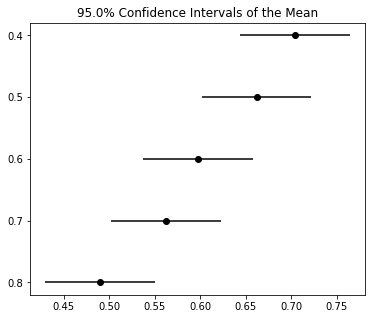

In [49]:
plot_stats(results)
plt.show()

In [50]:
create_report(results)

The statistical analysis was conducted for 5 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.065). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.079) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confide

In [51]:
acc_best_tl_open_set =  acc_tl_open_set['0.4']
acc_best_tl_open_set

0    0.66
1    0.70
2    0.70
3    0.71
4    0.75
Name: 0.4, dtype: float64

## Retrain Triplet Loss on training set + val set, and test it on test set

In [52]:
lr = 0.001
k = 1
d_t = 0.4


base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x = X_train, y = Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
#find the center point for each class in training set
support_tl = []
for i in np.unique(Y_train):
    support_tl.append(np.mean(embedding_train_tl[Y_train==i], axis=0))
        
support_tl = np.array(support_tl, dtype=float)
    
pred = []
temp_x = np.append(X_test, X_unseen, axis=0)
temp_y = np.append(Y_test, Y_unseen, axis=0)
    
arr = np.arange(temp_y.shape[0])
np.random.shuffle(arr)
    
temp_x = temp_x[arr]
temp_y = temp_y[arr]
    
for i in range(len(temp_y)):
    dists = []
    for j in range(len(np.unique(Y_train))):
        embedding_test = model_tl.predict(temp_x[i].reshape(1, 150, 150, 3))
        embedding_anchor = support_tl[j]
        dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
        dists.append(dist)
    if min(dists) >= d_t:
        pred.append('unseen')
    else:
        pred.append(knn_tl.predict(embedding_test)[0])

pred = np.array(pred)
    
acc_tl_test_open_set = round(np.mean(pred == temp_y), 2)
print('The accuracy on the test set with Open Dataset of Triplet Loss is {}'.format(acc_tl_test_open_set))

Epoch 1/10
20/20 [==============================] - 2s 65ms/step - loss: 0.9705
Epoch 2/10
20/20 [==============================] - 1s 63ms/step - loss: 0.8964
Epoch 3/10
20/20 [==============================] - 1s 63ms/step - loss: 0.7646
Epoch 4/10
20/20 [==============================] - 1s 65ms/step - loss: 0.5963
Epoch 5/10
20/20 [==============================] - 1s 65ms/step - loss: 0.6060
Epoch 6/10
20/20 [==============================] - 1s 64ms/step - loss: 0.5541
Epoch 7/10
20/20 [==============================] - 1s 63ms/step - loss: 0.4548
Epoch 8/10
20/20 [==============================] - 1s 63ms/step - loss: 0.3449
Epoch 9/10
20/20 [==============================] - 1s 64ms/step - loss: 0.3346
Epoch 10/10
20/20 [==============================] - 1s 63ms/step - loss: 0.1968
The accuracy on the test set with Open Dataset of Triplet Loss is 0.69


# Summary on Closed Set

In [53]:
# After tuning hps (lr and k), the best accuracy on val set.
best_vgg16 = table_vgg16.loc['0.0001']
best_cl = table_cl_closed_set.loc['0.0001_1']
best_tl = table_tl_closed_set.loc['0.001_1']

pd.DataFrame({'VGG16_(LR = 0.0001)': best_vgg16,
              'Contrastive_Loss(LR = 0.0001, k = 1)': best_cl, 
              'Triplet_Loss(LR = 0.001, k = 1)': best_tl
             })

,VGG16_(LR = 0.0001),"Contrastive_Loss(LR = 0.0001, k = 1)","Triplet_Loss(LR = 0.001, k = 1)"
mean,0.883188,0.884000,0.908000
std,0.023100,0.021909,0.013038


In [54]:
# Accuracy on test set

pd.DataFrame([acc_test_vgg16, acc_cl_test_closed_set, acc_tl_test_closed_set], index = ['VGG16', 'Contrastive_Loss', 'Triplet_Loss'], columns = ['Accuracy']).T

,VGG16,Contrastive_Loss,Triplet_Loss
Accuracy,0.91,0.94,0.94


# Summary on Open Set

In [55]:
# After tuning hps (d_t), the best accuracy on val set.

best_cl = table_cl_open_set.loc['0.4']
best_tl = table_tl_open_set.loc['0.4']

pd.DataFrame({'Contrastive_Loss(d_t = 0.4)': best_cl, 
              'Triplet_Loss(d_t = 0.4)': best_tl
             })

,Contrastive_Loss(d_t = 0.4),Triplet_Loss(d_t = 0.4)
mean,0.606000,0.704000
std,0.029665,0.032094


In [56]:
# Accuracy on test set

pd.DataFrame([acc_cl_test_open_set, acc_tl_test_open_set], index = ['Contrastive_Loss', 'Triplet_Loss'], columns = ['Accuracy']).T

,Contrastive_Loss,Triplet_Loss
Accuracy,0.66,0.69


# Statistical tests

In [57]:
from autorank import autorank, plot_stats, create_report

## Close Set

In [58]:
acc_closed_set = pd.DataFrame({'VGG16': acc_best_vgg16, 'Contrastive Loss': acc_best_cl_closed_set, 'Triplet Loss': acc_best_tl_closed_set})

In [59]:
results = autorank(acc_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
                  meanrank    median       mad  ci_lower  ci_upper  \
Triplet Loss           1.5  0.910000  0.014826      0.89      0.92   
VGG16                  2.0  0.903226  0.011957  0.859438  0.935484   
Contrastive Loss       2.5  0.900000       0.0      0.86       0.9   

                 effect_size   magnitude  
Triplet Loss             0.0  negligible  
VGG16                0.50299      medium  
Contrastive Loss    0.953874       large  
pvalue=0.2682624534699609
cd=1.4822885537191792
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[0.6939250230789185, 0.006469968240708113, 0.4211459457874298]
homoscedastic=True
pval_homogeneity=0.7689138473208496
homogeneity_test=levene
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=akinshin_gamma)


In [61]:
create_report(results)

The statistical analysis was conducted for 3 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population VGG16 (p=0.006). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.482 of the Nemenyi test.
We failed to reject the null hypothesis (p=0.268) of the Friedman test that there is no differen

## Open Set

In [62]:
acc_open_set = pd.DataFrame({'Contrastive Loss': acc_best_cl_open_set, 'Triplet Loss': acc_best_tl_open_set})

In [63]:
results = autorank(acc_open_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
                  meanrank   mean       std  ci_lower  ci_upper effect_size  \
Triplet Loss           1.0  0.704  0.032094  0.653831  0.754169         0.0   
Contrastive Loss       2.0  0.606  0.029665  0.559628  0.652372    3.171206   

                   magnitude  
Triplet Loss      negligible  
Contrastive Loss       large  
pvalue=0.007143112161973337
cd=None
omnibus=ttest
posthoc=None
all_normal=True
pvals_shapiro=[0.7772533297538757, 0.6657896041870117]
homoscedastic=True
pval_homogeneity=0.8820947397912708
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.025
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=cohen_d)


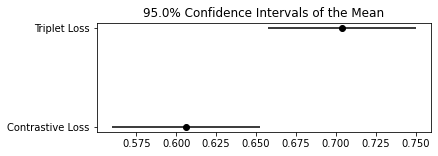

In [64]:
plot_stats(results)
plt.show()

In [65]:
create_report(results)

The statistical analysis was conducted for 2 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.666). Therefore, we assume that all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and both populations are normal, we use the t-test to determine differences between the mean values of the populations and report the mean value (M)and the standard deviation (SD) for each population. 
We reject the null hypothesis (p=0.007) of the paired t-test that the mean values of the populations Triplet Loss (M=0.704+-0.050, SD=0.032) and Contrastive Loss (M=0.606+-0.046, SD=0.030) are equal. Therefore, we assume that the mean value of Triplet Loss is significantly larger than the mean value of Contrastive Loss with a large effect size (d=3.171).


# Mis-classified monkeys

## VGG16 Classification Model

In [66]:
# choose best lr
lr = 0.001 

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=num_individuals, activation='softmax')
])

model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

model_vgg_16.fit(x=X_train, y=Y_train,
                 epochs=EPOCHS,
                 batch_size=batch_size,
                 verbose=1)

Epoch 1/10
20/20 [==============================] - 2s 63ms/step - loss: 3.9316 - acc: 0.3192
Epoch 2/10
20/20 [==============================] - 1s 64ms/step - loss: 0.7337 - acc: 0.7192
Epoch 3/10
20/20 [==============================] - 1s 62ms/step - loss: 0.3576 - acc: 0.9069
Epoch 4/10
20/20 [==============================] - 1s 63ms/step - loss: 0.2260 - acc: 0.9598
Epoch 5/10
20/20 [==============================] - 1s 62ms/step - loss: 0.1586 - acc: 0.9832
Epoch 6/10
20/20 [==============================] - 1s 62ms/step - loss: 0.1260 - acc: 0.9849
Epoch 7/10
20/20 [==============================] - 1s 62ms/step - loss: 0.0892 - acc: 0.9908
Epoch 8/10
20/20 [==============================] - 1s 62ms/step - loss: 0.0709 - acc: 0.9987
Epoch 9/10
20/20 [==============================] - 1s 62ms/step - loss: 0.0558 - acc: 0.9984
Epoch 10/10
20/20 [==============================] - 1s 62ms/step - loss: 0.0405 - acc: 1.0000


In [67]:
pred = model_vgg_16.predict_classes(X_test)

monkeys, mis_classes = np.unique(Y_test[pred != Y_test], return_counts=True)
pd.DataFrame({'monkeys': np.array(labels)[monkeys], 'mis_classfied': mis_classes})

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,monkeys,mis_classfied
0,Arani,6
1,Inti,6
2,Ocuri,4
3,Poco,4
4,Rattaplan,4


## Contrastive Loss

In [68]:
from sklearn.neighbors import KNeighborsClassifier

# choose best lr and k
lr = 0.0001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

    
imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
featsA = model_cl(imgA)
featsB = model_cl(imgB)
   
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1)
    
embedding_train_cl = []
for i in range(len(Y_train)):
        embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
x_test_embedding = model_cl.predict(X_test)
pred = knn_cl.predict(x_test_embedding)

2021-10-15 01:09:11.671300: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 670140000 exceeds 10% of free system memory.


Epoch 1/10
39/39 [==============================] - 6s 124ms/step - loss: 0.2420
Epoch 2/10
39/39 [==============================] - 5s 126ms/step - loss: 0.1677
Epoch 3/10
39/39 [==============================] - 5s 124ms/step - loss: 0.1341
Epoch 4/10
39/39 [==============================] - 5s 126ms/step - loss: 0.1077
Epoch 5/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0917
Epoch 6/10
39/39 [==============================] - 5s 124ms/step - loss: 0.0801
Epoch 7/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0673
Epoch 8/10
39/39 [==============================] - 5s 124ms/step - loss: 0.0590
Epoch 9/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0449
Epoch 10/10
39/39 [==============================] - 5s 125ms/step - loss: 0.0437


In [69]:
monkeys, mis_classes = np.unique(Y_test[pred != Y_test], return_counts=True)
pd.DataFrame({'monkeys': np.array(labels)[monkeys], 'mis_classfied': mis_classes})

,monkeys,mis_classfied
0,Arani,5
1,Inti,5
2,Ocuri,11
3,Rattaplan,4


## Triplet Loss

In [70]:
# choose best lr and k
lr = 0.001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
        layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x=X_train, y= Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
x_test_embedding = model_tl.predict(X_test)
pred = knn_tl.predict(x_test_embedding)

Epoch 1/10
20/20 [==============================] - 2s 63ms/step - loss: 0.9704
Epoch 2/10
20/20 [==============================] - 1s 63ms/step - loss: 0.8819
Epoch 3/10
20/20 [==============================] - 1s 63ms/step - loss: 0.7490
Epoch 4/10
20/20 [==============================] - 1s 66ms/step - loss: 0.6478
Epoch 5/10
20/20 [==============================] - 1s 63ms/step - loss: 0.5228
Epoch 6/10
20/20 [==============================] - 1s 63ms/step - loss: 0.5415
Epoch 7/10
20/20 [==============================] - 1s 63ms/step - loss: 0.4900
Epoch 8/10
20/20 [==============================] - 1s 62ms/step - loss: 0.4050
Epoch 9/10
20/20 [==============================] - 1s 63ms/step - loss: 0.3606
Epoch 10/10
20/20 [==============================] - 1s 63ms/step - loss: 0.2284


In [71]:
monkeys, mis_classes = np.unique(Y_test[pred != Y_test], return_counts=True)
pd.DataFrame({'monkeys': np.array(labels)[monkeys], 'mis_classfied': mis_classes})

,monkeys,mis_classfied
0,Arani,5
1,Inti,6
2,Ocuri,6
3,Poco,2
4,Rattaplan,4
